In [ ]:
pip install scikit-plot


In [ ]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

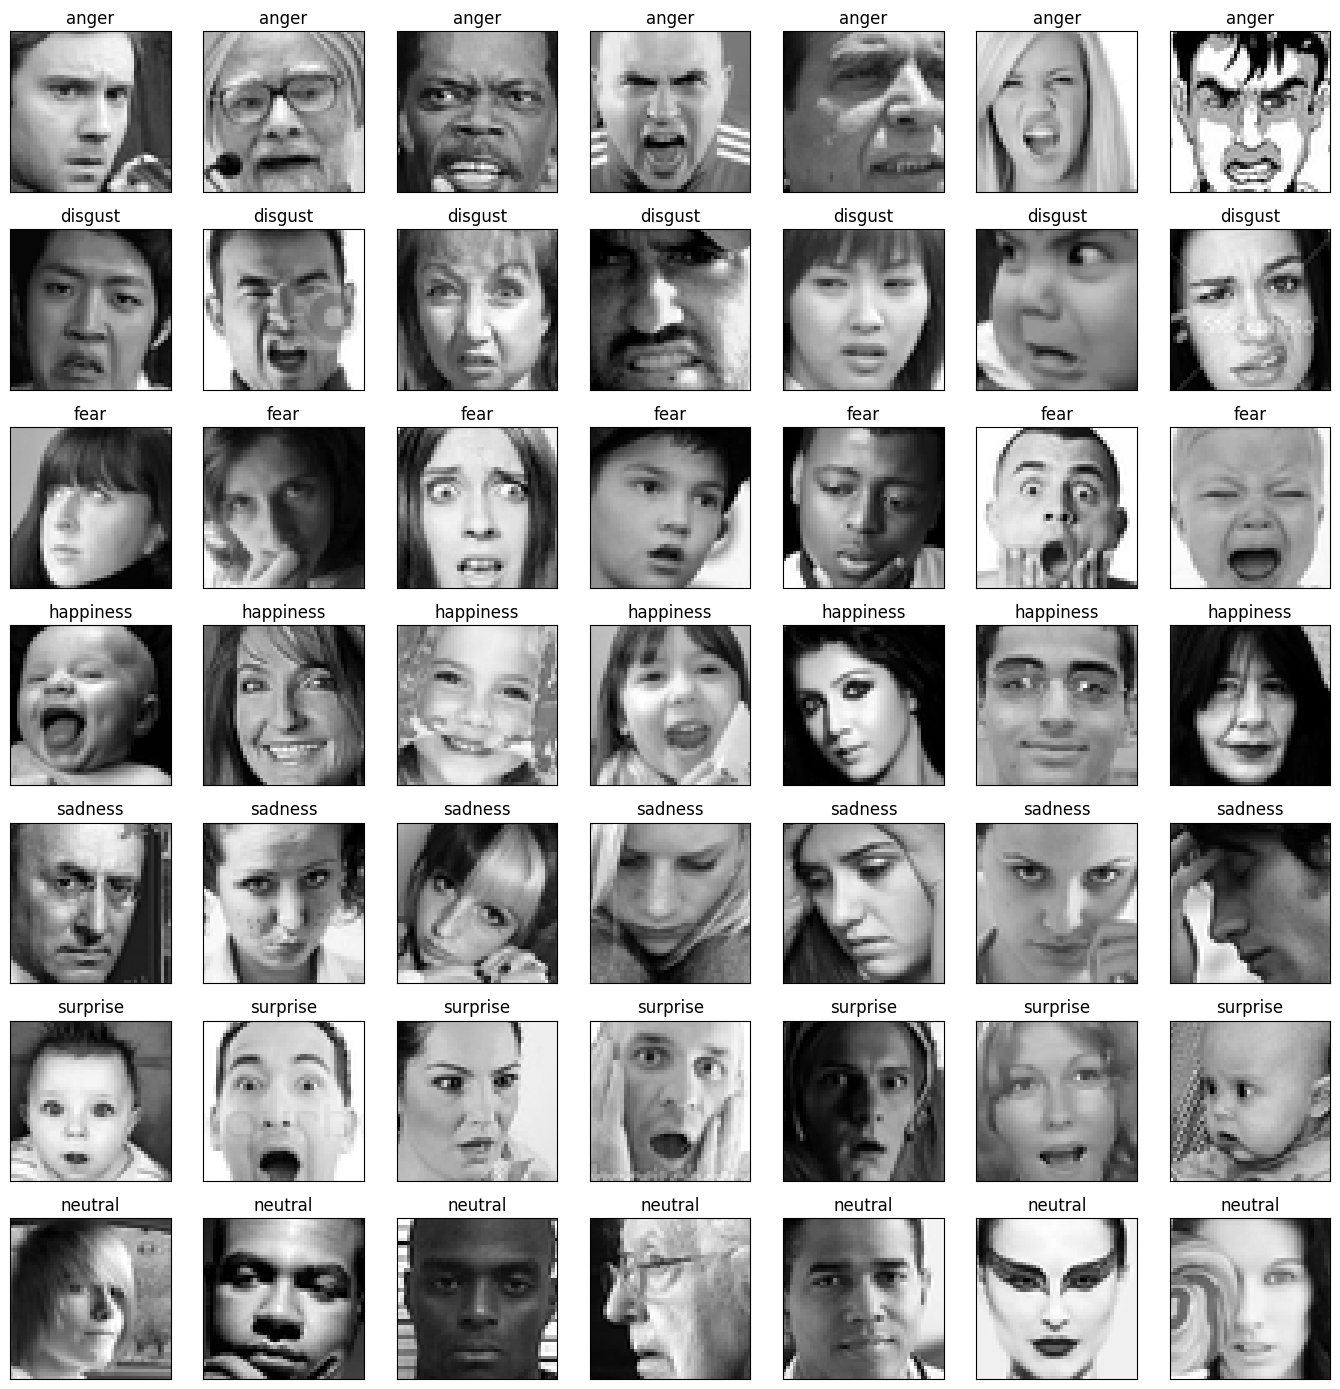

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32')) #reshaping each input string into a 48*48 image
img_array = np.stack(img_array, axis = 0) #Stacking each layer

In [ ]:
img_array.shape #35887 Number of images in your dataset

(35887, 48, 48)

In [ ]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


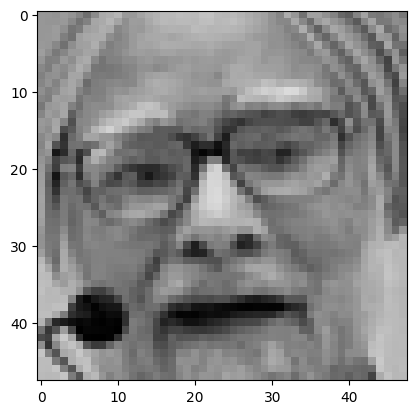

In [ ]:
pyplot.imshow(img_features[1].astype(np.uint8));

In [ ]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle = True,
                                                      stratify = img_labels,
                                                      test_size = 0.1,
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [ ]:
del df
del img_features
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:


X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
#Softmax- Used in the output layer for multi-class classification, normalizing the outputs to represent a probability distribution.
    return model

In [ ]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [ ]:
# batch size of 32 performs the best.
batch_size = 32
epochs = 50
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
num_train_samples = y_train.shape[0]
num_valid_samples = y_valid.shape[0]

print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_valid_samples)

Number of training samples: 32298
Number of validation samples: 3589


In [ ]:
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/50
1009/1009 [==============================] - 72s 61ms/step - loss: 1.4756 - accuracy: 0.4213 - val_loss: 1.2749 - val_accuracy: 0.5010 - lr: 1.0000e-04
Epoch 2/50
1009/1009 [==============================] - 61s 60ms/step - loss: 1.2461 - accuracy: 0.5238 - val_loss: 1.1425 - val_accuracy: 0.5692 - lr: 1.0000e-04
Epoch 3/50
1009/1009 [==============================] - 61s 60ms/step - loss: 1.1630 - accuracy: 0.5581 - val_loss: 1.1297 - val_accuracy: 0.5773 - lr: 1.0000e-04
Epoch 4/50
1009/1009 [==============================] - 61s 60ms/step - loss: 1.1038 - accuracy: 0.5829 - val_loss: 1.0737 - val_accuracy: 0.5935 - lr: 1.0000e-04
Epoch 5/50
1009/1009 [==============================] - 61s 60ms/step - loss: 1.0555 - accuracy: 0.6027 - val_loss: 1.0336 - val_accuracy: 0.6108 - lr: 1.0000e-04
Epoch 6/50
1009/1009 [==============================] - 60s 59ms/step - loss: 1.0186 - accuracy: 0.6199 - val_loss: 0.9677 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 7/50
1009/1009 [

In [ ]:
model_yaml = model.to_json()
with open("modelnew.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("new_modelnew.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


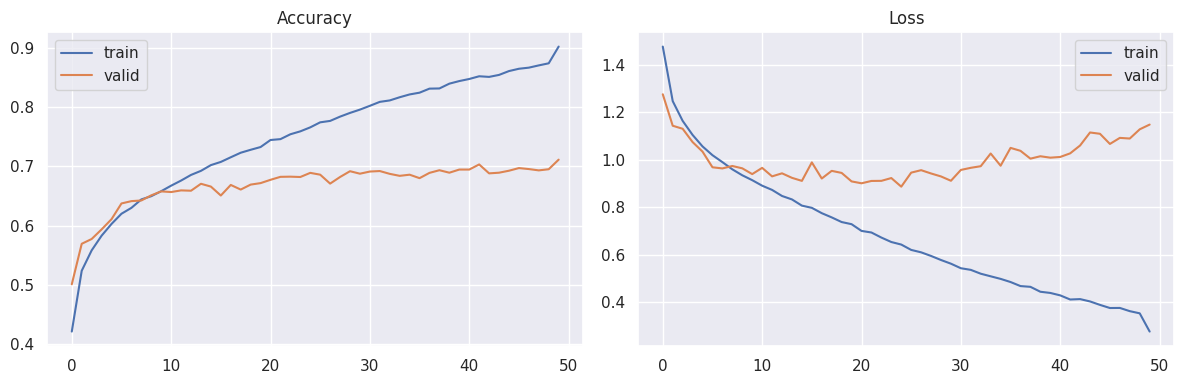

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


113/113 [==============================] - 2s 14ms/step
total wrong validation predictions: 1037


              precision    recall  f1-score   support

           0       0.65      0.66      0.65       495
           1       0.88      0.67      0.76        55
           2       0.64      0.54      0.59       512
           3       0.88      0.87      0.87       899
           4       0.56      0.64      0.60       608
           5       0.83      0.73      0.78       400
           6       0.67      0.71      0.69       620

    accuracy                           0.71      3589
   macro avg       0.73      0.69      0.71      3589
weighted avg       0.72      0.71      0.71      3589

total right validation predictions: 2552




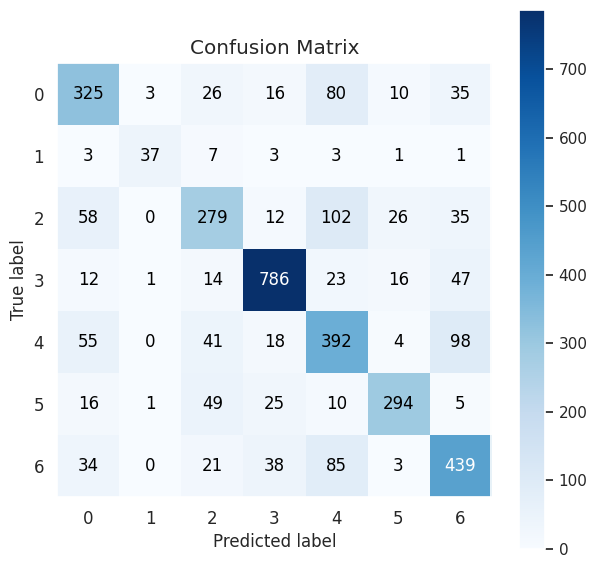

In [ ]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))
print(f'total right validation predictions: {np.sum(np.argmax(y_valid, axis=1) == yhat_valid)}\n\n')

In [ ]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 85ms/step


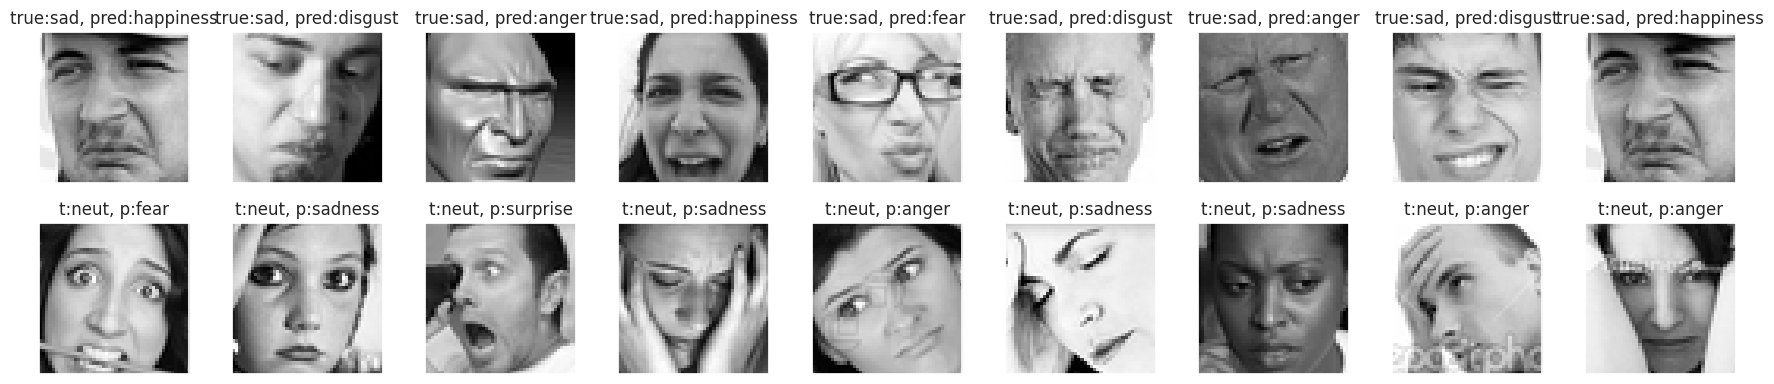

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()

In [ ]:
# Make predictions on the validation data
y_pred_prob = model.predict(X_valid)
y_pred = np.argmax(y_pred_prob, axis=1)  # Assuming it's a multiclass classification task

# Now you can use y_valid and y_pred to compute various metrics


113/113 [==============================] - 2s 14ms/step


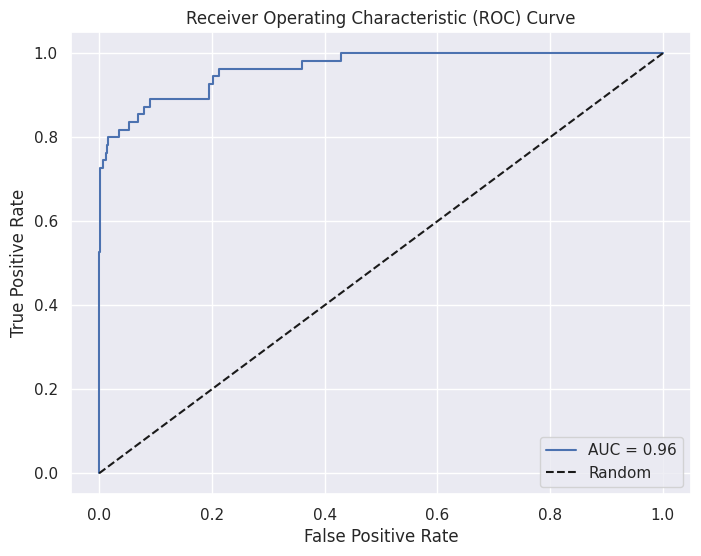

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'y_valid' contains the true labels and 'y_pred_prob' contains the predicted probabilities

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(np.argmax(y_valid, axis=1), y_pred_prob[:, 1], pos_label=1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


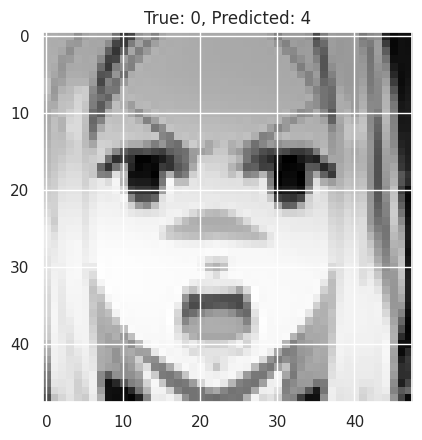

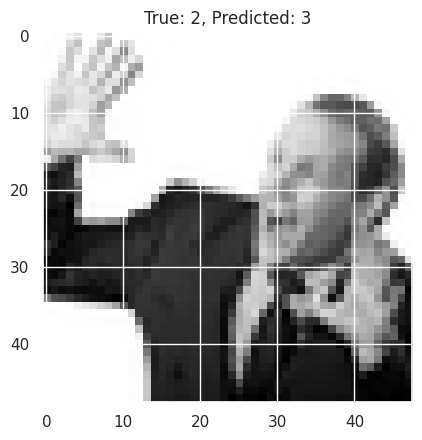

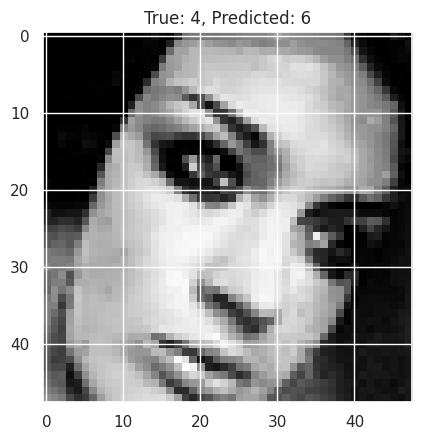

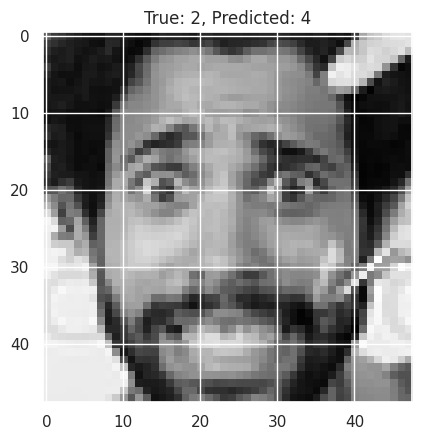

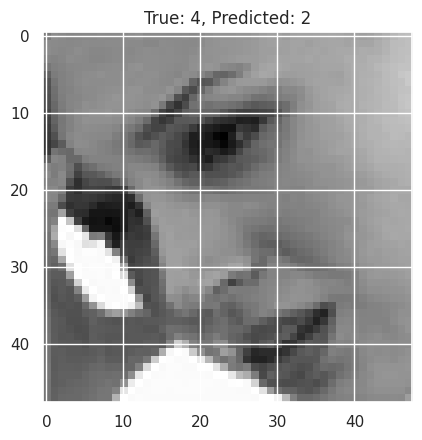

In [ ]:
# Find indices of misclassified samples
misclassified_indices = np.where(np.argmax(y_valid, axis=1) != y_pred)[0]

# Display some misclassified images
num_display = min(5, len(misclassified_indices))
for i in range(num_display):
    index = misclassified_indices[i]
    true_label = np.argmax(y_valid[index])
    pred_label = y_pred[index]

    plt.imshow(X_valid[index][:, :, 0], cmap='gray')  # Assuming images are grayscale
    plt.title(f'True: {true_label}, Predicted: {pred_label}')
    plt.show()



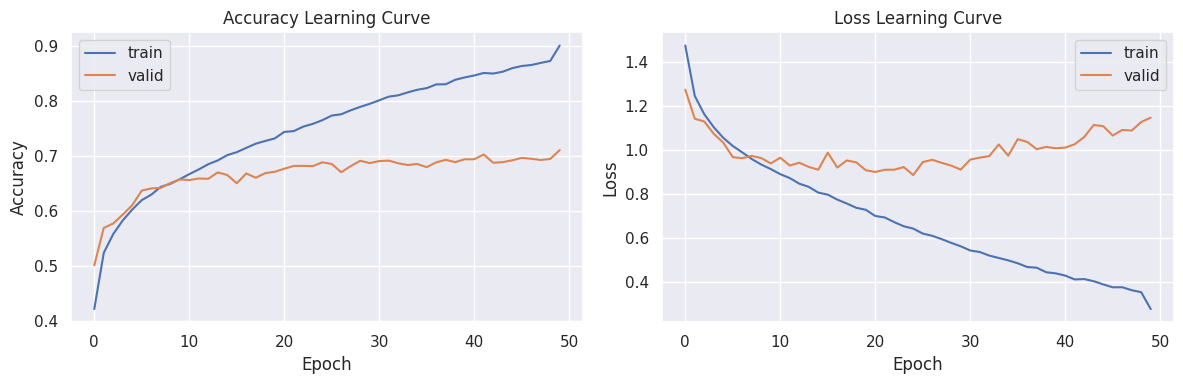

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Loss Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 80ms/step


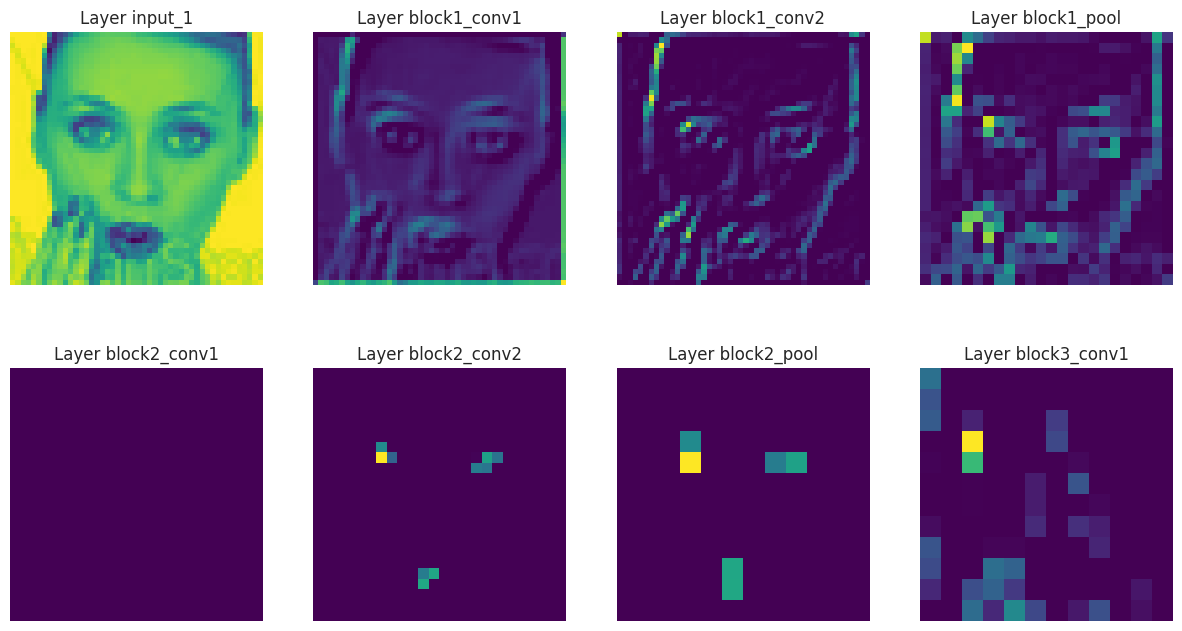

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
import random

# Assuming 'model' is your VGG19 model and X_valid is your validation data
layer_names = [layer.name for layer in model.layers[:8]]  # Choose the number of layers to visualize
activation_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output for layer_name in layer_names])

# Limit the number of samples for visualization
num_samples_to_visualize = 10  # Adjust as needed
sample_indices = random.sample(range(len(X_valid)), num_samples_to_visualize)
X_valid_subset = X_valid[sample_indices]

# Generate activation maps
activations = activation_model.predict(X_valid_subset, batch_size=32)

# Plot activation maps
plt.figure(figsize=(15, 8))
for i in range(len(activations)):
    activation_map = activations[i][0, :, :, 0]  # Assuming the output shape is (batch_size, height, width, channels)
    plt.subplot(2, 4, i+1)
    plt.imshow(activation_map, cmap='viridis')
    plt.title('Layer {}'.format(layer_names[i]))
    plt.axis('off')

plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

print(classification_report(y_true_classes, y_pred_classes))


113/113 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       495
           1       0.88      0.67      0.76        55
           2       0.64      0.54      0.59       512
           3       0.88      0.87      0.87       899
           4       0.56      0.64      0.60       608
           5       0.83      0.73      0.78       400
           6       0.67      0.71      0.69       620

    accuracy                           0.71      3589
   macro avg       0.73      0.69      0.71      3589
weighted avg       0.72      0.71      0.71      3589



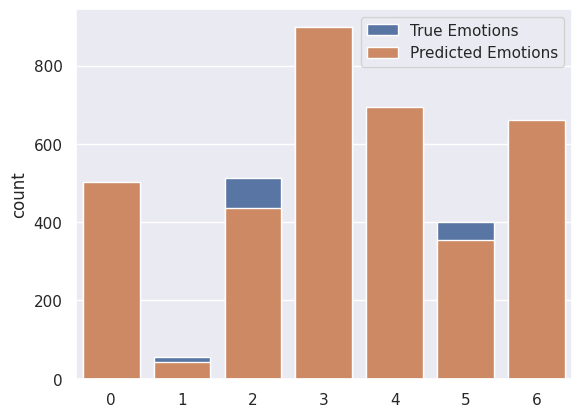

In [ ]:
import seaborn as sns

sns.countplot(x=np.argmax(y_valid, axis=1), label='True Emotions')
sns.countplot(x=np.argmax(y_pred, axis=1), label='Predicted Emotions')
plt.legend()
plt.show()


<ipython-input-40-7fcf675e332e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true_classes, label='True Emotions', palette='viridis')
<ipython-input-40-7fcf675e332e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_classes, label='Predicted Emotions', palette='viridis')


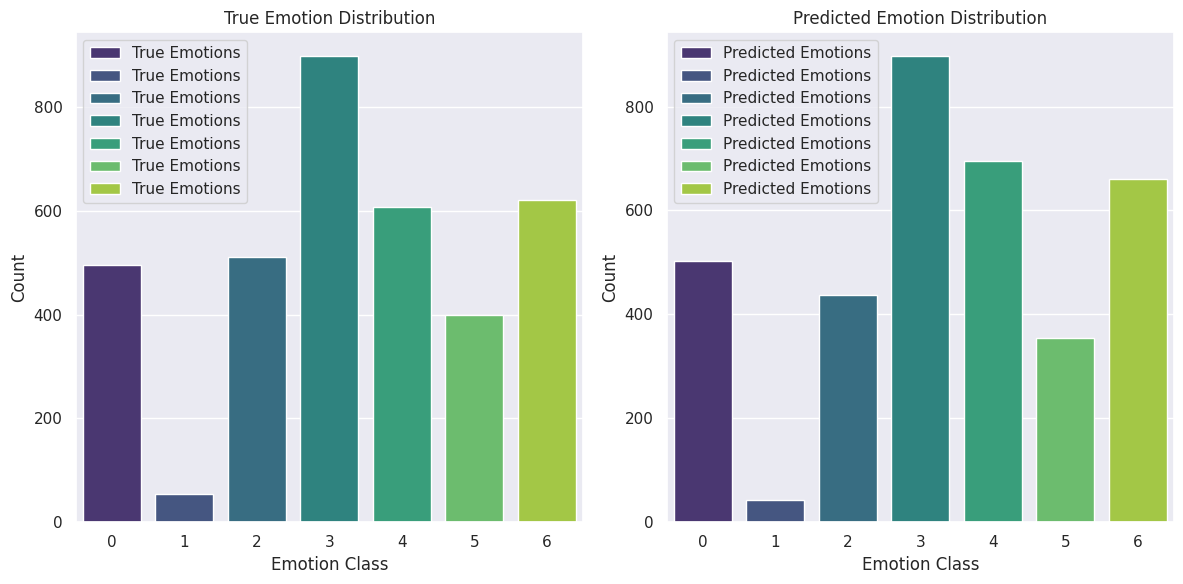

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'y_true' and 'y_pred' are your true and predicted labels
y_true_classes = np.argmax(y_valid, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

plt.figure(figsize=(12, 6))

# Plot true emotions distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y_true_classes, label='True Emotions', palette='viridis')
plt.title('True Emotion Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.legend()

# Plot predicted emotions distribution
plt.subplot(1, 2, 2)
sns.countplot(x=y_pred_classes, label='Predicted Emotions', palette='viridis')
plt.title('Predicted Emotion Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-41-5d60b4ce80c7>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true_classes, label='True Emotions', palette='viridis')
<ipython-input-41-5d60b4ce80c7>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_classes, label='Predicted Emotions', palette='viridis')


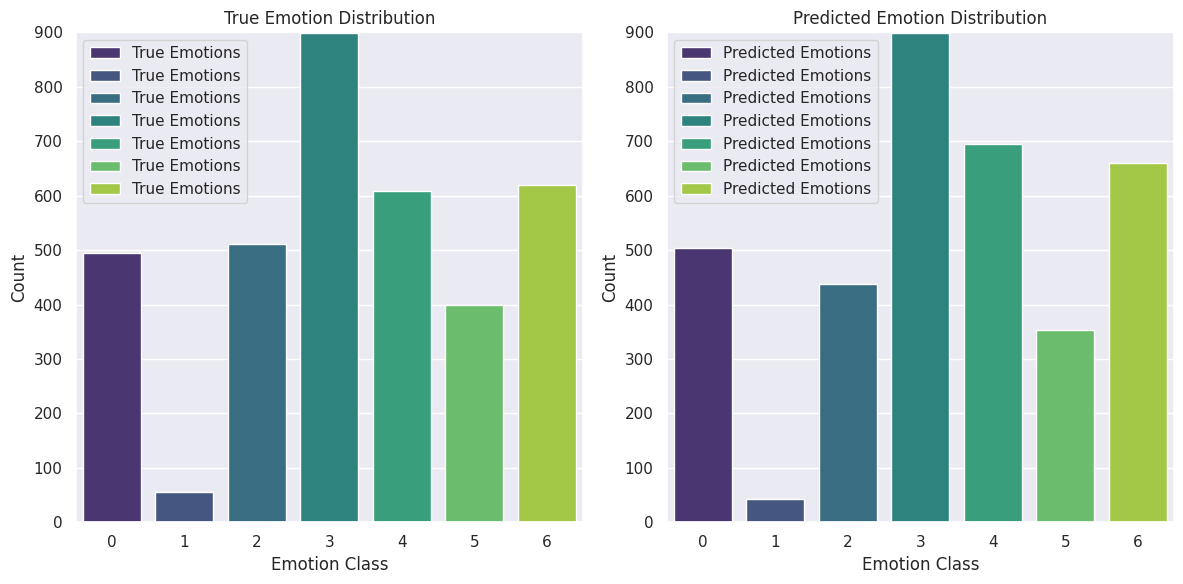

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'y_true' and 'y_pred' are your true and predicted labels
y_true_classes = np.argmax(y_valid, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the maximum count for either true or predicted emotions
max_count = np.max([np.bincount(y_true_classes), np.bincount(y_pred_classes)])

plt.figure(figsize=(12, 6))

# Plot true emotions distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y_true_classes, label='True Emotions', palette='viridis')
plt.title('True Emotion Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.ylim(0, max_count + 1)  # Set y-axis range
plt.legend()

# Plot predicted emotions distribution
plt.subplot(1, 2, 2)
sns.countplot(x=y_pred_classes, label='Predicted Emotions', palette='viridis')
plt.title('Predicted Emotion Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.ylim(0, max_count + 1)  # Set y-axis range
plt.legend()

plt.tight_layout()
plt.show()


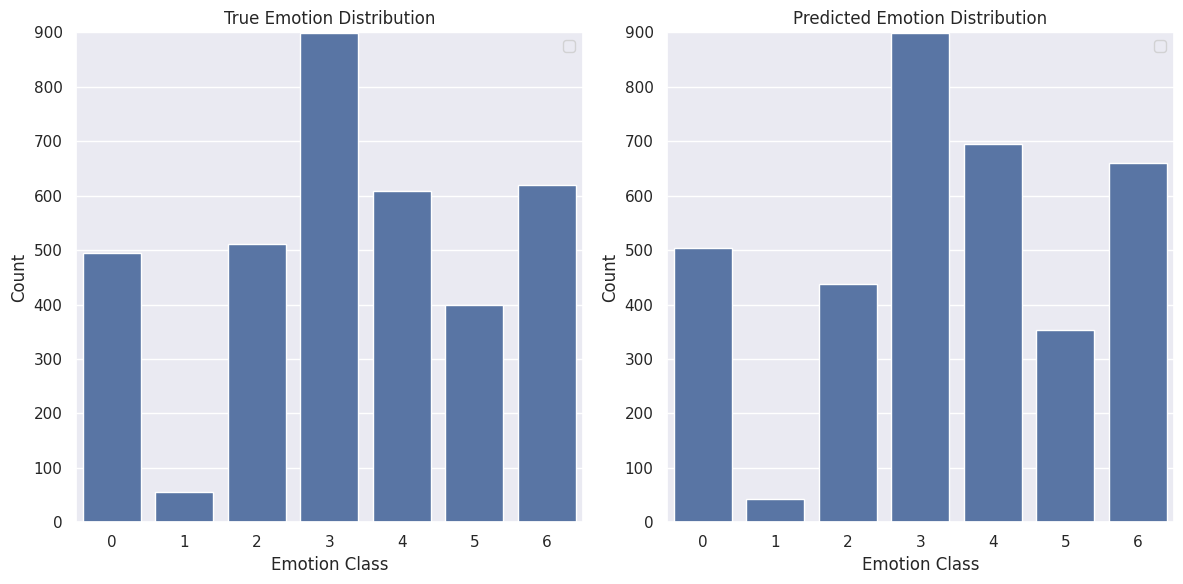

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'y_true' and 'y_pred' are your true and predicted labels
y_true_classes = np.argmax(y_valid, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the maximum count for either true or predicted emotions
max_count = np.max([np.bincount(y_true_classes), np.bincount(y_pred_classes)])

plt.figure(figsize=(12, 6))

# Plot true emotions distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y_true_classes)
plt.title('True Emotion Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.ylim(0, max_count + 1)  # Set y-axis range
plt.legend()

# Plot predicted emotions distribution
plt.subplot(1, 2, 2)
sns.countplot(x=y_pred_classes)
plt.title('Predicted Emotion Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.ylim(0, max_count + 1)  # Set y-axis range
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-43-f5bc66ca5e74>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


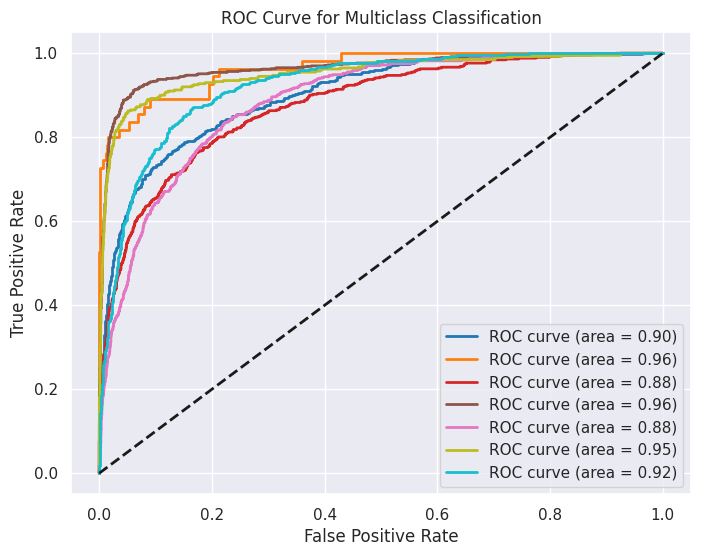

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'y_true_classes' and 'y_pred' are your true and predicted labels
# 'num_classes' is the number of classes in your classification problem

# Binarize the true labels
y_true_bin = label_binarize(y_true_classes, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a color map for the curves
colors = plt.cm.get_cmap('tab10', num_classes)

# Plot ROC curves with different colors for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()


<ipython-input-44-87c96feedff8>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


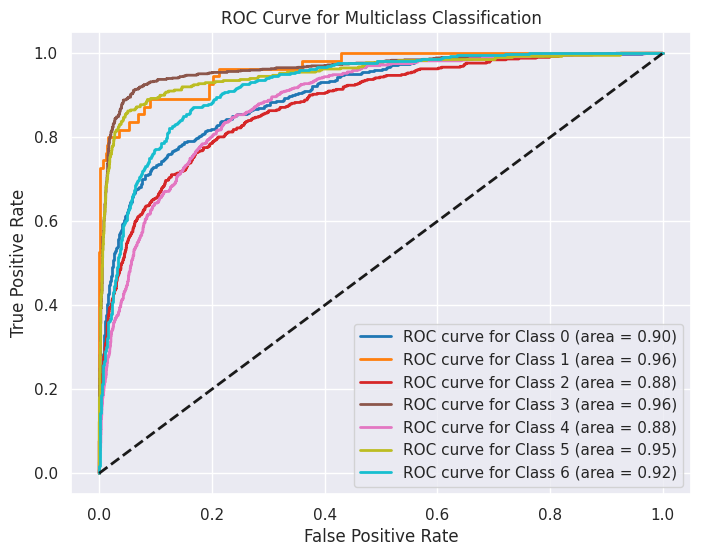

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'y_true_classes' and 'y_pred' are your true and predicted labels
# 'num_classes' is the number of classes in your classification problem

# Binarize the true labels
y_true_bin = label_binarize(y_true_classes, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a color map for the curves
colors = plt.cm.get_cmap('tab10', num_classes)

# Plot ROC curves with different colors for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label='ROC curve for Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()


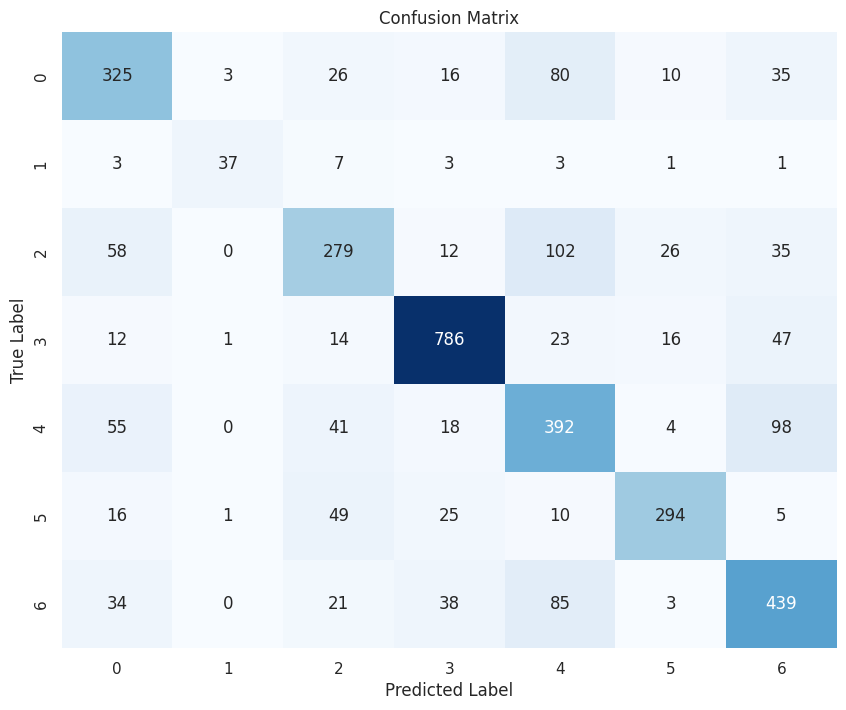

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_true_classes' and 'y_pred_classes' are your true and predicted classes
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


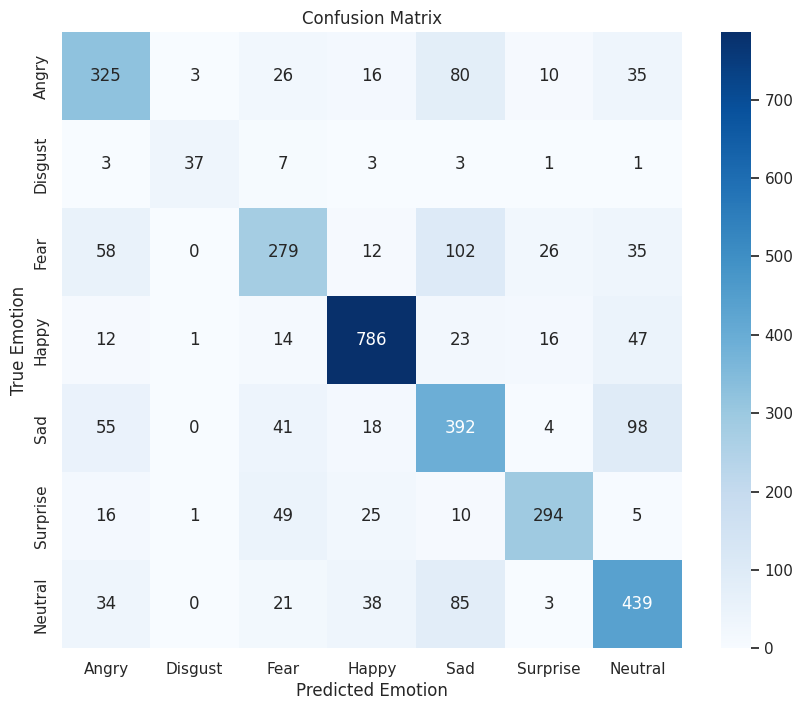

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'y_true_classes' and 'y_pred_classes' are your true and predicted classes
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Get emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.show()


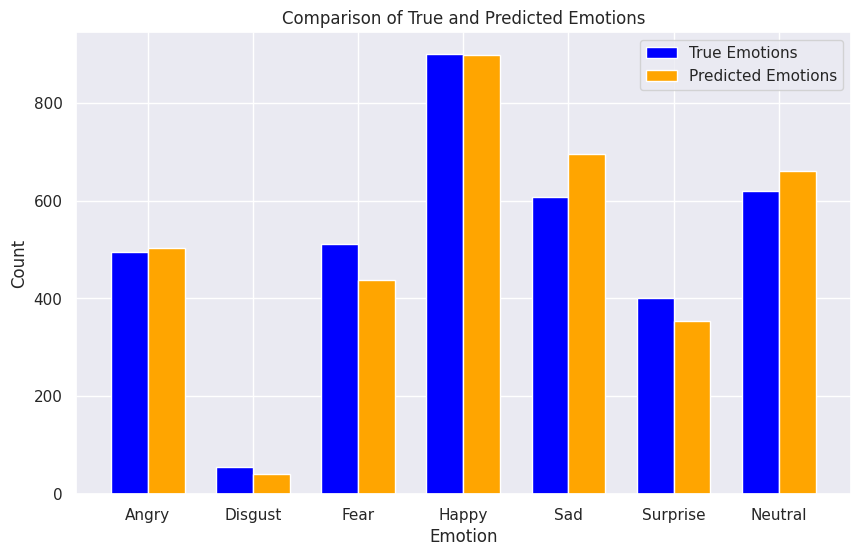

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'y_true_classes' and 'y_pred_classes' are your true and predicted classes
# Calculate the count of each emotion in true and predicted classes
true_counts = np.bincount(y_true_classes)
pred_counts = np.bincount(y_pred_classes)

# Get emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
x = np.arange(len(emotion_labels))

# Plot bar graph
plt.figure(figsize=(10, 6))
bar_width = 0.35
plt.bar(x - bar_width/2, true_counts, bar_width, label='True Emotions', color='blue')
plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted Emotions', color='orange')

# Add labels and title
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Comparison of True and Predicted Emotions')
plt.xticks(x, emotion_labels)
plt.legend()

plt.show()


In [ ]:
model_yaml = model.to_json()
with open("modelnew.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("fermodelnew.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import Model

# Assuming 'model' is your trained model
model.save("fer_model.h5")

In [ ]:
# Save model architecture to JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5 file
model.save_weights("model_weights.h5")


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/fer_model.h5")


In [ ]:
try:
    model.save("model.h5")
    print("Model saved successfully.")
except Exception as e:
    print("Error saving model:", e)


Model saved successfully.
